In [1]:
import math
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import cv2
plt.rcParams['image.cmap'] = 'gray'

In [2]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.transform import resize
from scipy import ndimage as nd

### import functions from scripts

In [3]:
import os
os.chdir('../saliency_model/')

In [4]:
from utils import *
from itti_koch_features import *

## Load the images

In [5]:
img = mpimg.imread('../imgs/balloons.png')
# img2 = cv2.imread('../imgs/balloons.png')

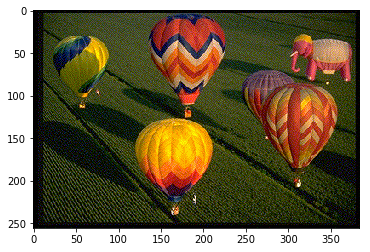

In [6]:
plt.imshow(img);

convert to double if image is uint8

In [7]:
# TODO 

---

## Determine the size and the number of center scales:  
First we scale the image to different sizes, so it has different resolutions we can work with.

In [8]:
mapwidth = 64
mapheight = round(img.shape[0] * (mapwidth / img.shape[1]))
scalars = [1, 2, 3]

img_list = downsample_image(img, mapheight, mapwidth, scalars)

In [9]:
mapsize = [ round(np.size(img,0) / np.size(img,1) * mapwidth), mapwidth ];
mapsize
# chanmap = chanmap + wj * imresize(maps{ci}{cj}, mapSize ); #TODO: weighted scale

[43, 64]

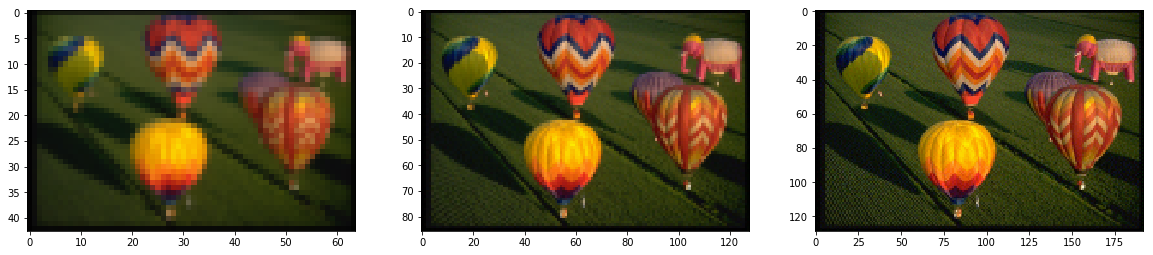

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_list[0])
ax[1].imshow(img_list[1])
ax[2].imshow(img_list[2]);

---

## split to channels & compute salience in each

### Channel 1: Compute intensity

In [11]:
#from skimage.morphology import disk
#from skimage.filters.rank import mean

In [12]:
# img_avg = mean(img_hat, disk(5));
# comment: until now, img_hat was just the R-dimension of the RGB image

Compute intensity of the image as average over the RGB values:

In [13]:
img_int = compute_intensity(img_list)

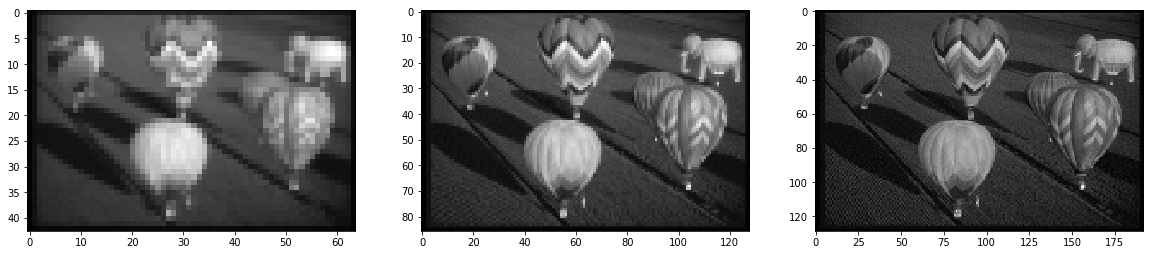

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_int[0])
ax[1].imshow(img_int[1])
ax[2].imshow(img_int[2]);

## Compute saliency map: apply center-surround to feature map
### has to be done for each feature map

Convolve the feature maps with the center surround function / Mexican Hat to get the saliency maps.

In [15]:
# convolve with mexican hat function (receptive Field)
sigma1 = 2
sigma2 = 3
rf = receptive_field_matrix(lambda x, y: mexican_hat(x, y, sigma1, sigma2))
# TODO replace img by the saliency maps

img_hat = []
for i in img_int:
    img_hat.append(signal.convolve(i, rf, mode='same'))

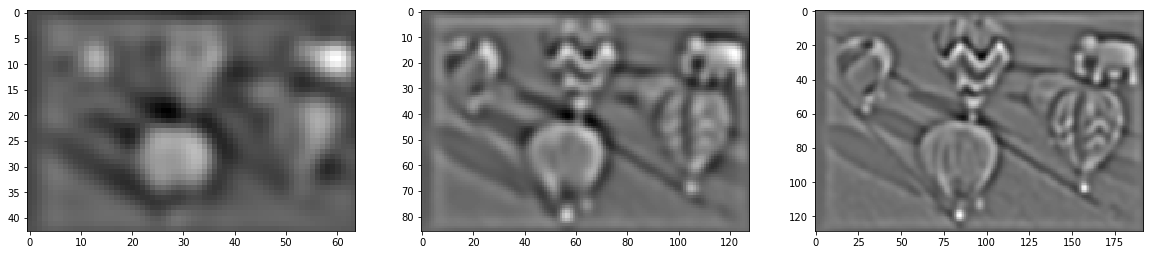

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_hat[0])
ax[1].imshow(img_hat[1])
ax[2].imshow(img_hat[2]);

Now, what is done in the original MATLAB code is the following:   
(1) create 1-dim Gausskernel and convolve it with the image twice (in two dimensions) - I think this should be the same as what we directly do in two dimensions? They also only use a Gaussian kernel and not a real receptive field...  
(2) after convolution, get the saliency map by subtracting the convoluted image from the original intensities and squaring the difference

**>> Why??**

In [17]:
# implement step (2):
sal_map = []
for i in range(len(img_int)):
    sal_map.append((img_int[i] - img_hat[i])**2)

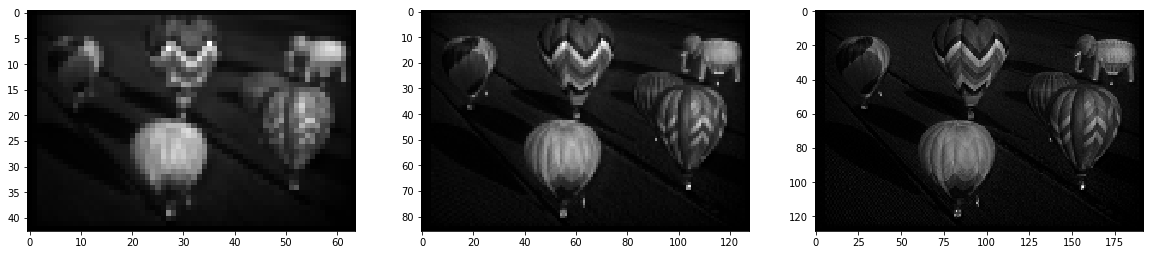

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(sal_map[0])
ax[1].imshow(sal_map[1])
ax[2].imshow(sal_map[2]);

## next steps:
(1) construct several mexican hat functions with different sigmas, create a weighted sum of the created saliency maps (weight according to their "peakiness", as done in MATLAB?) and normalize  
(2) if the channel has different features (like RGB in colors), create also a weighted sum of those saliency maps  
(3) combine the saliency maps for the different channels (i.e. intensity, color, orientation and color bias) to one saliency map by a weighted sum  
(3a) top-down modulation here?

-----

## Other features: 
Not in the features file yet.

### Compute color channels

In [19]:
import cv2 as cv

In [20]:
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

In [21]:
r_list, g_list, b_list =[], [], []

for ii in img_list:
    R, G, B = cv.split(ii)
    r_list.append(R) 
    g_list.append(G)
    b_list.append(B)
    

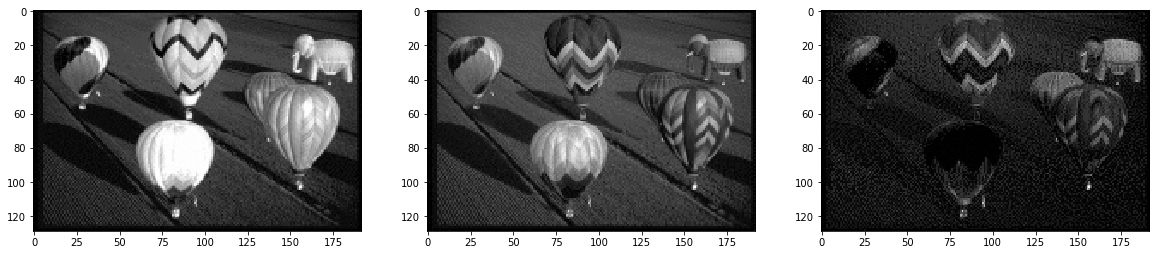

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(R)
ax[1].imshow(G)
ax[2].imshow(B);

In [23]:
# convolve with mexican hat function (receptive Field)
sigma1 = 2
sigma2 = 3
rf = receptive_field_matrix(lambda x, y: mexican_hat(x, y, sigma1, sigma2))
# TODO replace img by the saliency maps

r_hat = []
for i in r_list:
    r_hat.append(signal.convolve(i, rf, mode='same'))
    
g_hat = []
for i in g_list:
    g_hat.append(signal.convolve(i, rf, mode='same'))
    
b_hat = []
for i in b_list:
    b_hat.append(signal.convolve(i, rf, mode='same'))

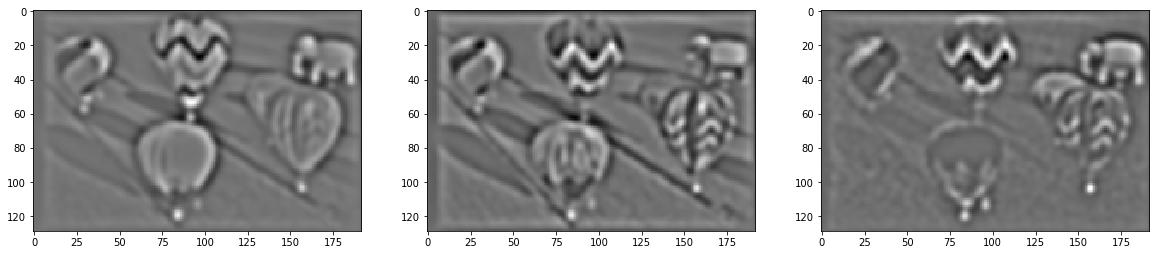

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(r_hat[2])
ax[1].imshow(g_hat[2])
ax[2].imshow(b_hat[2]);

In [25]:
sal_r = []
sal_r_resize = []
sal_r_sum = np.zeros(mapsize)

# for ii in r_hat:
for i in range(len(r_hat)):
    sal_r.append((img_int[i] - r_hat[i])**2)

for ii in sal_r:
    temp = resize(ii, mapsize, mode='constant')
    sal_r_resize.append(temp)
    sal_r_sum = sal_r_sum + temp

/home/ateska/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


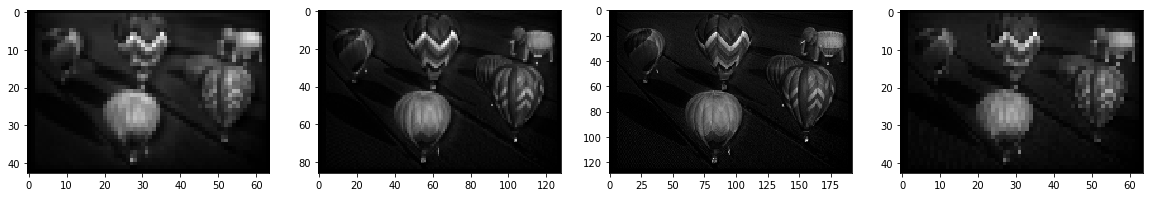

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(sal_r[0])
ax[1].imshow(sal_r[1])
ax[2].imshow(sal_r[2]);
ax[3].imshow(sal_r_sum);

In [27]:
sal_g = []
sal_g_resize = []
sal_g_sum = np.zeros(mapsize)

# for ii in r_hat:
for i in range(len(g_hat)):
    sal_g.append((img_int[i] - g_hat[i])**2)

for ii in sal_g:
    temp = resize(ii, mapsize, mode='constant')
    sal_g_resize.append(temp)
    sal_g_sum = sal_g_sum + temp

/home/ateska/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


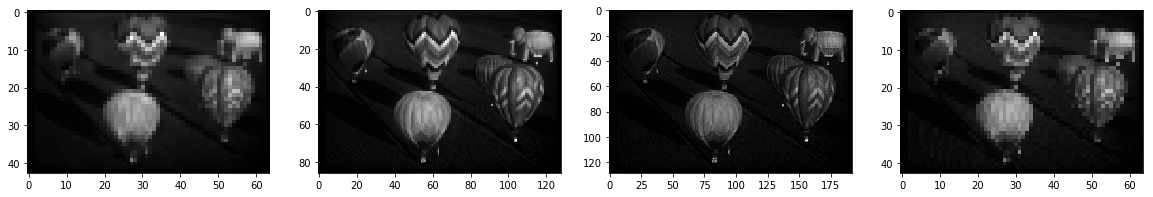

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(sal_g[0])
ax[1].imshow(sal_g[1])
ax[2].imshow(sal_g[2]);
ax[3].imshow(sal_g_sum);

In [29]:
sal_b = []
sal_b_resize = []
sal_b_sum = np.zeros(mapsize)

# for ii in r_hat:
for i in range(len(b_hat)):
    sal_b.append((img_int[i] - b_hat[i])**2)

for ii in sal_b:
    temp = resize(ii, mapsize, mode='constant')
    sal_b_resize.append(temp)
    sal_b_sum = sal_b_sum + temp

/home/ateska/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


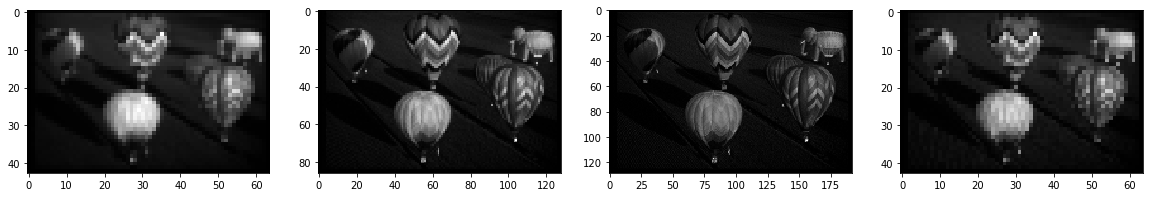

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(sal_b[0])
ax[1].imshow(sal_b[1])
ax[2].imshow(sal_b[2]);
ax[3].imshow(sal_b_sum);

In [31]:
# by = ((b - np.min(r,g)) / np.max(np.max(r,g),b)) # (B-Y)
# rg = ((r - g) /np.max(np.max(r,g),b)); # (R-G)

In [32]:
r = sal_r_sum
g = sal_g_sum
b = sal_b_sum

In [33]:
by = np.divide((b - np.minimum(r,g)), np.maximum(np.maximum(r,g),b)) # (B-Y)

In [34]:
rg = ((r - g) /np.maximum(np.maximum(r,g),b)); # (R-G)

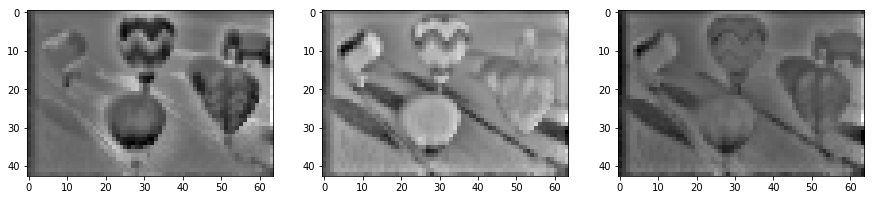

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(rg)
ax[1].imshow(by);
ax[2].imshow(rg+by);

### Orientation filter

In [36]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

In [37]:
theta = 1
theta = theta / 4. * np.pi
sigma = 4
frequency = 0.25

kernel = np.real(gabor_kernel(frequency, theta=theta,
                              sigma_x=sigma, sigma_y=sigma))

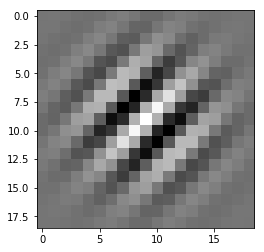

In [38]:
plt.imshow(kernel);

In [39]:
np.shape(kernel)

(19, 19)

In [40]:
from scipy import ndimage as nd

In [41]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [42]:
from skimage import data
brick = img_as_float(data.load('brick.png'))
np.shape(brick)

(512, 512)

In [43]:
orientation = nd.convolve(img_list[1][:,:,0], kernel)

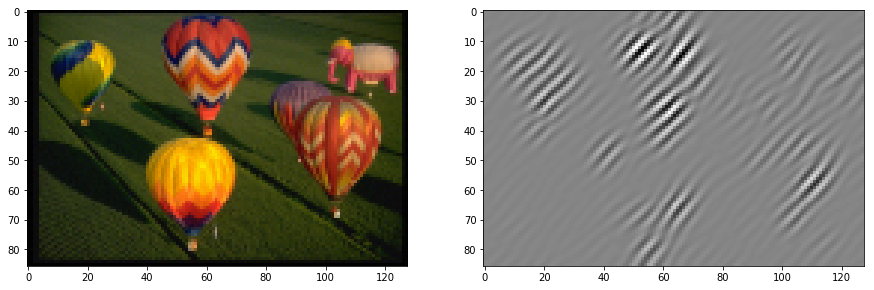

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img_list[1])
ax[1].imshow(orientation);

### Color Bias

In [45]:
from skimage.color import rgb2hsv

In [46]:
img_hsv = rgb2hsv(img)

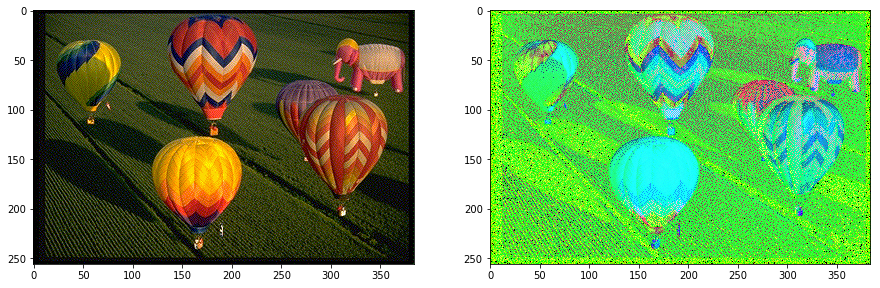

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img)
ax[1].imshow(img_hsv);

How its done in Matlab

D = zeros(size(img));           % allocate matrix

colorHue = param.colorHue;      % get the color hue
colorHue = 240;      % get the color hue

img_hsv = rgb2hsv(img);         % change to hsv space

[M, N] = size(img_hsv(:,:,1));  % get matrix size of each color
hue = repmat(colorHue, M, N);   % allocate matrix for division

% calculate hsv distance each channel
for i = 1 : size(img,3)
    ang1 = img_hsv(:,:,i) - hue;
    ang2 = hue - img_hsv(:,:,i);

    D(:,:,i) = min(ang1, ang2);
    X = min(ang1, ang2);
    chan{end+1} = min(ang1, ang2);
end

----